# Analyze racer combos

References:
* Main source of scraped statistics: http://japan-mk.blog.jp/
* Additional source of statistics: https://www.mariowiki.com/Mario_Kart_8_Deluxe_in-game_statistics
* Matplotlib colormap reference: https://matplotlib.org/stable/tutorials/colors/colormaps.html
* Plotly marker symbol reference: https://plotly.com/python/marker-style/#custom-marker-symbols

## Initial setup

### Import libraries

In [1]:
# Native data definition imports
from typing import Tuple, List
from abc import ABC, abstractmethod
from collections import namedtuple
from dataclasses import dataclass

# Native functional imports
import os
from pathlib import Path
import json
import urllib.request

# Data processing imports
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Data analysis imports
from paretoset import paretoset

# Data visualization imports
from IPython.display import Markdown
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

import param
import panel as pn
from panel.theme import Material # or 'Bootstrap'

from pytablewriter import MarkdownTableWriter

# Data visualization debugging imports
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1931 as plot_chroma_1931
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1960UCS as plot_chroma_1960
from colour.plotting import plot_RGB_chromaticities_in_chromaticity_diagram_CIE1976UCS as plot_chroma_1976

### Pre-initialization

In [2]:
# Utility functions & classes

# Read JSON content from given filename
def read_json(filename):
    with open(filename) as fp:
        return json.load(fp)


# Pre-initialization
DataWidget = namedtuple('DataWidget', ['name', 'widget', 'debug'])

IS_RUNNING_NOTEBOOK = '__file__' not in globals()
IS_RUNNING_BOKEH = __name__.startswith('bokeh')

MAIN_DIRECTORY = os.path.abspath('') if IS_RUNNING_NOTEBOOK else os.path.dirname(__file__)
ROOT_DIRECTORY = str(Path(MAIN_DIRECTORY).parent.absolute())

# Help markdown URLs & error help content
GSC_HEATMAP_HELP_URL   = 'https://raw.githubusercontent.com/tejashah88/mk8d-combo-playground/main/help/game-statistic-comparision-heatmap.md'
KC_VISUALIZER_HELP_URL = 'https://raw.githubusercontent.com/tejashah88/mk8d-combo-playground/main/help/kart-combo-visualizer.md'
CD_DEBUGGER_HELP_URL   = 'https://raw.githubusercontent.com/tejashah88/mk8d-combo-playground/main/help/chromaticity-diagram-debugger.md'
ERROR_HELP_CONTENT     = 'Error: Unable to fetch help content. Check your internet connection or <a href="https://github.com/tejashah88/mk8d-combo-playground" target="_blank">open a new issue</a>.'

pn.extension(
    # Panel extensions
    'plotly',
    'tabulator',
    'floatpanel',
    comms = 'ipywidgets',
    theme = 'default',
    design = Material,
    notifications = True,
    # NOTE: Throttle slider values until mouse button is released
    throttled = True,
    disconnect_notification='Connection lost, try reloading the page!',
    ready_notification='Application fully loaded!',
)

pio.renderers.default = 'iframe'
pn.state.notifications.position = 'bottom-right'
NOTIFICATION_DURATION = 2500


# Load scraped statistics
dframes = {
    'Character': pd.read_csv(ROOT_DIRECTORY + '/stats/Character.csv').set_index('Character'),
    'Frame':     pd.read_csv(ROOT_DIRECTORY + '/stats/Frame.csv').set_index('Parts'),
    'Tire':      pd.read_csv(ROOT_DIRECTORY + '/stats/Tire.csv').set_index('Parts'),
    'Glider':    pd.read_csv(ROOT_DIRECTORY + '/stats/Glider.csv').set_index('Parts'),
}

all_combos_df = (
    pd.read_csv(ROOT_DIRECTORY + '/stats/All-Combos.csv')
        .set_index(['Character', 'Frame', 'Tire', 'Glider'])
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'80109168-229b-4a8c-a7b6-80f021efbc34': {'version…

## Data visualization

### Pre-initialization

In [3]:
# Prepare important feature descriptors
ALL_COMBO_PARTS = list(dframes.keys())
ALL_GAME_STATISTICS = dframes[ALL_COMBO_PARTS[0]].columns.tolist()

PLOT_WIDTH  = 800 if IS_RUNNING_NOTEBOOK else 1000
PLOT_HEIGHT = 800

In [4]:
@dataclass
class ColorScalePoint:
    label: str
    pos: float
    color: Tuple[float, float, float]

    @property
    def color_srgb(self):
        return f'rgb{self.color}'


    @property
    def color_hex(self):
        return '#%02x%02x%02x' % tuple([int(intensity_val * 255) for intensity_val in self.color])


@dataclass
class DetailedColorScale:
    cs_points: List[ColorScalePoint]

    
    def native(self):
        return [(point.pos, point.color_srgb) for point in self.cs_points]

    
    @property
    def labels(self):
        return [point.label for point in self.cs_points]

    
    @property
    def positions(self):
        return [point.pos for point in self.cs_points]

    
    @property
    def colors(self):
        return [point.color for point in self.cs_points]

    
    def generate_tickvals(self, data_arr):
        return np.interp(
            self.positions,
            [0.0, 1.0],
            [np.min(data_arr), np.max(data_arr)]
        )

# Define colorscales for general data points
BALANCED_CSCALE=DetailedColorScale([
    ColorScalePoint(label='Worst', pos=0.0, color=(0.7, 0.0, 0.0)), # red
    ColorScalePoint(label='Okay' , pos=0.5, color=(1.0, 1.0, 0.0)), # yellow
    ColorScalePoint(label='Best' , pos=1.0, color=(0.0, 0.7, 0.0)), # green
])

POSITIVE_LEAN_CSCALE=DetailedColorScale([
    ColorScalePoint(label='Worst', pos=0.0, color=(0.7, 0.0, 0.0)), # red
    ColorScalePoint(label='Okay' , pos=0.7, color=(1.0, 1.0, 0.0)), # yellow
    ColorScalePoint(label='Best' , pos=1.0, color=(0.0, 0.7, 0.0)), # green
])

POSITIVE_HARD_LEAN_CSCALE=DetailedColorScale([
    ColorScalePoint(label='Worst', pos=0.0, color=(0.7, 0.0, 0.0)), # red
    ColorScalePoint(label='Okay' , pos=0.9, color=(1.0, 1.0, 0.0)), # yellow
    ColorScalePoint(label='Best' , pos=1.0, color=(0.0, 0.7, 0.0)), # green
])

# Define colorscales for pareto-optimal data points
PARETO_BALANCED_CSCALE=DetailedColorScale([
    ColorScalePoint(label='Worst', pos=0.0, color=(0.0, 0.0, 0.7)),  # dark blue
    ColorScalePoint(label='Okay' , pos=0.5, color=(0.0, 0.5, 0.85)), # brighter blue
    ColorScalePoint(label='Best' , pos=1.0, color=(0.0, 1.0, 1.0)),  # aqua
])

PARETO_POSITIVE_LEAN_CSCALE=DetailedColorScale([
    ColorScalePoint(label='Worst', pos=0.0, color=(0.0, 0.0, 0.7)), # dark blue
    ColorScalePoint(label='Okay' , pos=0.7, color=(0.0, 0.0, 1.0)), # 100% blue
    ColorScalePoint(label='Best' , pos=1.0, color=(0.0, 1.0, 1.0)), # aqua
])

PARETO_POSITIVE_HARD_LEAN_CSCALE=DetailedColorScale([
    ColorScalePoint(label='Worst', pos=0.0, color=(0.0, 0.0, 0.7)), # dark blue
    ColorScalePoint(label='Okay' , pos=0.9, color=(0.0, 0.0, 1.0)), # 100% blue
    ColorScalePoint(label='Best' , pos=1.0, color=(0.0, 1.0, 1.0)), # aqua
])

##########################################
### README: ONLY USE ALIASES FOR PLOTS ###
##########################################

# Aliases for general data point color scales
HISTOGRAM_CSCALE = BALANCED_CSCALE
MARKER_CSCALE    = POSITIVE_LEAN_CSCALE

# Aliases for pareto-optimal data point color scales
PARETO_MARKER_CSCALE = PARETO_BALANCED_CSCALE

# Aliases for singular points
YOUR_COMBO_COLOR        = '#8A2BE2' # purple
SELECTED_COMBO_COLOR    = '#FF00FF' # magenta
THEORETICAL_BEST_COLOR  = '#00FF00' # lime green
THEORETICAL_WORST_COLOR = '#FF0000' # red

### Game Statistics Comparision Heatmap

This histogram visualizer allows the user to compare the various in-game statistics for each kart feature.

In [5]:
class GameStatComparisionHeatmap(param.Parameterized):
    combo_part = param.Selector(objects=ALL_COMBO_PARTS, default='Character')
    game_stats = param.ListSelector(
        objects=ALL_GAME_STATISTICS,
        default=[
            'Speed - Land',
            'Acceleration',
            'Handling - Land',
            'Mini Turbo',
        ]
    )
    

    @param.depends('combo_part', 'game_stats')
    def make_plot(self):
        return pn.pane.Plotly(
            go.Figure()
                .add_trace(
                    go.Heatmap(
                        x=self.game_stats,
                        y=dframes[self.combo_part].index,
                        z=dframes[self.combo_part][self.game_stats],
                        texttemplate='%{z}',
                        textfont={'size': 12},
                        colorscale=HISTOGRAM_CSCALE.native(),
                        xgap=2, ygap=2,
                    )
                ),
                width=PLOT_WIDTH,
                height=PLOT_HEIGHT,
                # sizing_mode='scale_both',
                config={'modeBarButtonsToRemove': ['zoom', 'pan']}
        )
        

    def render_help(self):
        try:
            with urllib.request.urlopen(GSC_HEATMAP_HELP_URL) as res:
                HELP_CONTENT = res.read().decode()
        except urllib.error.HTTPError:
            HELP_CONTENT = ERROR_HELP_CONTENT
            
        return pn.pane.Markdown(HELP_CONTENT)
        

    def render(self):
        return (
            pn.Row(
                pn.WidgetBox(
                    pn.Param(self.param.combo_part),
                    pn.Param(self.param.game_stats, widgets={'game_stats': pn.widgets.CheckBoxGroup}),
                ),
                self.make_plot,
                name='Game Statistics Comparision Heatmap'
            )
        )

### Kart Combo Visualizer

This scatterplot visualizer allows the user to compute and visualize pareto optimal solutions for a
specific set of in-game stats. The cool part is being able to choose either 2 or 3 stats for either
a 2D or 3D scatterplot rendition, allowing for a richer exploration of the data.

#### Define scatterplot features

In [6]:
class ScatterplotFeature(ABC):
    def __init__(self, pos_data, color_data, axes_titles=['x-axis', 'y-axis', 'z-axis']):
        # Check that we have the same number of positional and color data points
        num_pos_points = pos_data.shape[0]
        num_color_points = color_data.shape[0]
        if num_pos_points != num_color_points:
            raise Exception(f'Found {num_pos_points} positional vs. {num_color_points} color points')
        
        # Check that the dimensions of positional points are either 2 or 3
        num_dim_pos_points = pos_data.shape[1]
        if num_dim_pos_points != 2 and num_dim_pos_points != 3:
            raise Exception(f'Number of dimensions is incompatible with scatterplot feature: {num_dim_pos_points}')
        
        self.pos_data    = pos_data
        self.color_data  = color_data
        self.axes_titles = axes_titles

    
    @abstractmethod
    def render_2d(self, pos_data, color_data, axes_titles=['x-axis', 'y-axis']):
        return #raise NotImplementedError('This method has not been implemented')

    
    @abstractmethod
    def render_3d(self, pos_data, color_data, axes_titles=['x-axis', 'y-axis', 'z-axis']):
        return #raise NotImplementedError('This method has not been implemented')


    def render(self, *args, **kwargs):
        num_dims = self.pos_data.shape[1]
        if num_dims == 2:
            return self.render_2d(*args, **kwargs)
        elif num_dims == 3:
            return self.render_3d(*args, **kwargs)
        else:
            raise Exception(f'Number of dimensions is incompatible with scatterplot feature: {num_dims}')


class AllCombosPlot(ScatterplotFeature):
    def render_2d(self):
        hover_info_2d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<extra></extra>'
        
        return go.Scatter(
            name='All Combos',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            mode='markers',
            hovertemplate=hover_info_2d,
            marker=dict(
                size=12,
                color=self.color_data,
                line=dict(width=1, color='DarkSlateGrey'),
                colorbar=dict(
                    title='All Combos',
                    len=0.7,
                    x=1.05,
                    tickmode='array',
                    tickvals=MARKER_CSCALE.generate_tickvals(self.color_data),
                    ticktext=MARKER_CSCALE.labels,
                ),
                colorscale=MARKER_CSCALE.native(),
                opacity=1.0
            )
        )
    

    def render_3d(self):
        hover_info_3d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<br>{self.axes_titles[2]} = %{{z}}<extra></extra>'
        
        return go.Scatter3d(
            name='All Combos',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            z=self.pos_data[:, 2],
            mode='markers',
            hovertemplate=hover_info_3d,
            marker=dict(
                size=6,
                color=self.color_data,
                line=dict(width=1, color='DarkSlateGrey'),
                colorbar=dict(
                    title='All Combos',
                    len=0.7,
                    x=1.05,
                    tickmode='array',
                    tickvals=MARKER_CSCALE.generate_tickvals(self.color_data),
                    ticktext=MARKER_CSCALE.labels,
                ),
                colorscale=MARKER_CSCALE.native(),
                opacity=1.0
            )
        )


class OptimalCombosPlot(ScatterplotFeature):
    def render_2d(self):
        hover_info_2d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<extra></extra>'
        
        return go.Scatter(
            name='Optimal Combos',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            mode='markers',
            hovertemplate=hover_info_2d,
            marker=dict(
                size=16,
                color=self.color_data,
                line=dict(width=2, color='DarkSlateGrey'),
                colorbar=dict(
                    title='Optimal Combos',
                    len=0.7,
                    x=1.25,
                    tickmode='array',
                    tickvals=PARETO_MARKER_CSCALE.generate_tickvals(self.color_data),
                    ticktext=PARETO_MARKER_CSCALE.labels,
                ),
                colorscale=PARETO_MARKER_CSCALE.native(),
                opacity=1.0
            )
        )
    

    def render_3d(self):
        hover_info_3d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<br>{self.axes_titles[2]} = %{{z}}<extra></extra>'
        
        return go.Scatter3d(
            name='Optimal Combos',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            z=self.pos_data[:, 2],
            mode='markers',
            hovertemplate=hover_info_3d,
            marker=dict(
                size=10,
                color=self.color_data,
                line=dict(width=2, color='DarkSlateGrey'),
                colorbar=dict(
                    title='Optimal Combos',
                    len=0.7,
                    x=1.25,
                    tickmode='array',
                    tickvals=PARETO_MARKER_CSCALE.generate_tickvals(self.color_data),
                    ticktext=PARETO_MARKER_CSCALE.labels,
                ),
                colorscale=PARETO_MARKER_CSCALE.native(),
                opacity=1.0
            )
        )


class YourComboPointPlot(ScatterplotFeature):
    def __init__(self, pos_data, axes_titles=['x-axis', 'y-axis', 'z-axis']):
        super().__init__(
            pos_data=pos_data,
            color_data=np.array([[0]]),
            axes_titles=axes_titles
        )
        
    
    def render_2d(self):
        hover_info_2d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<extra></extra>'
        
        return go.Scatter(
            name='Your Combo',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            mode='markers',
            hovertemplate=hover_info_2d,
            marker=dict(
                size=16,
                color=YOUR_COMBO_COLOR,
                line=dict(width=2, color='DarkSlateGrey'),
                opacity=1.0
            )
        )
    

    def render_3d(self):
        hover_info_3d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<br>{self.axes_titles[2]} = %{{z}}<extra></extra>'
        
        return go.Scatter3d(
            name='Your Combo',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            z=self.pos_data[:, 2],
            mode='markers',
            hovertemplate=hover_info_3d,
            marker=dict(
                size=10,
                color=SELECTED_COMBO_COLOR,
                line=dict(width=2, color='DarkSlateGrey'),
                opacity=1.0
            )
        )


class TheoryBestPointPlot(ScatterplotFeature):
    def __init__(self, pos_data, axes_titles=['x-axis', 'y-axis', 'z-axis']):
        super().__init__(
            pos_data=pos_data,
            color_data=np.array([[0]]),
            axes_titles=axes_titles
        )

    
    def render_2d(self):
        hover_info_2d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<extra></extra>'
        
        return go.Scatter(
            name='Theoretical Best',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            mode='markers',
            hovertemplate=hover_info_2d,
            marker=dict(
                symbol='diamond',
                size=16,
                color=THEORETICAL_BEST_COLOR,
                line=dict(width=2, color='DarkSlateGrey'),
                opacity=1.0
            )
        )
    

    def render_3d(self):
        hover_info_3d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<br>{self.axes_titles[2]} = %{{z}}<extra></extra>'
        
        return go.Scatter3d(
            name='Theoretical Best',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            z=self.pos_data[:, 2],
            mode='markers',
            hovertemplate=hover_info_3d,
            marker=dict(
                symbol='diamond',
                size=10,
                color=THEORETICAL_BEST_COLOR,
                line=dict(width=2, color='DarkSlateGrey'),
                opacity=1.0
            )
        )


class TheoryWorstPointPlot(ScatterplotFeature):
    def __init__(self, pos_data, axes_titles=['x-axis', 'y-axis', 'z-axis']):
        super().__init__(
            pos_data=pos_data,
            color_data=np.array([[0]]),
            axes_titles=axes_titles
        )

    
    def render_2d(self):
        hover_info_2d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<extra></extra>'
        
        return go.Scatter(
            name='Theoretical Worst',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            mode='markers',
            hovertemplate=hover_info_2d,
            marker=dict(
                symbol='diamond',
                size=16,
                color=THEORETICAL_WORST_COLOR,
                line=dict(width=2, color='DarkSlateGrey'),
                opacity=1.0
            )
        )
    

    def render_3d(self):
        hover_info_3d = f'{self.axes_titles[0]} = %{{x}}<br>{self.axes_titles[1]} = %{{y}}<br>{self.axes_titles[2]} = %{{z}}<extra></extra>'
        
        return go.Scatter3d(
            name='Theoretical Worst',
            x=self.pos_data[:, 0],
            y=self.pos_data[:, 1],
            z=self.pos_data[:, 2],
            mode='markers',
            hovertemplate=hover_info_3d,
            marker=dict(
                symbol='diamond',
                size=10,
                color=THEORETICAL_WORST_COLOR,
                line=dict(width=2, color='DarkSlateGrey'),
                opacity=1.0
            )
        )

#### Setup scatterplot

In [7]:
class KartComboVisualizer(param.Parameterized):
    target_stats = param.ListSelector(
        objects=ALL_GAME_STATISTICS,
        default=[
            # These are the ideal stats to optimize for most in-game scenarios
            'Speed - Land',
            'Mini Turbo',
            # 'Acceleration',
        ]
    )

    visible_layers = param.ListSelector(
        objects=[
            'All Combos',
            'Optimal Combos',
            'Your Combo',
            'Theoretical Best',
            'Theoretical Worst',
        ],
        default=[
            'All Combos',
            'Optimal Combos',
            'Theoretical Best',
            'Theoretical Worst',
        ]
    )

    x_stat_weight = param.Magnitude(1.0, step=0.1)
    y_stat_weight = param.Magnitude(1.0, step=0.1)
    z_stat_weight = param.Magnitude(1.0, step=0.1)

    selected_character = param.Selector(objects=[])
    selected_frame     = param.Selector(objects=[])
    selected_tire      = param.Selector(objects=[])
    selected_glider    = param.Selector(objects=[])
    
    def __init__(self, all_combos, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.all_combos_dframe = all_combos

        # Initialize GUI components
        self.target_stats_list = pn.Param(
            self.param.target_stats,
            widgets={'target_stats': pn.widgets.CheckBoxGroup}
        )

        self.visible_layers_list = pn.Param(
            self.param.visible_layers,
            widgets={'visible_layers': pn.widgets.CheckBoxGroup}
        )

        self.x_stat_weight_param = pn.Param(self.param.x_stat_weight)
        self.y_stat_weight_param = pn.Param(self.param.y_stat_weight)
        self.z_stat_weight_param = pn.Param(self.param.z_stat_weight)

        self.param.selected_character.objects = self.all_combos_dframe.index.get_level_values('Character').tolist()
        self.param.selected_frame.objects     = self.all_combos_dframe.index.get_level_values('Frame').tolist()
        self.param.selected_tire.objects      = self.all_combos_dframe.index.get_level_values('Tire').tolist()
        self.param.selected_glider.objects    = self.all_combos_dframe.index.get_level_values('Glider').tolist()

        self.selected_character = self.param.selected_character.objects[0]
        self.selected_frame     = self.param.selected_frame.objects[0]
        self.selected_tire      = self.param.selected_tire.objects[0]
        self.selected_glider    = self.param.selected_glider.objects[0]

        self.selected_character_param = pn.Param(self.param.selected_character)
        self.selected_frame_param     = pn.Param(self.param.selected_frame)
        self.selected_tire_param      = pn.Param(self.param.selected_tire)
        self.selected_glider_param    = pn.Param(self.param.selected_glider)
        
        self.selected_stats = pn.pane.Markdown('')
        self.selected_meta_stats = pn.pane.Markdown('')
        
        # NOTE: We don't initialize a DataFrame since no data points are selected on initialization
        self.selected_combos = pn.widgets.Tabulator(
            layout='fit_data_table',
            selectable=False,
            pagination='local',
            page_size=20,
            header_filters=True,
            row_content=self._event_on_row_select,
            theme='semantic-ui',
            theme_classes=['very-compact'],
            align='center'
        )
        self.selected_combos.visible = False

        self.main_plot = None

    
    @pn.cache(max_items=8, policy='LFU')
    def _compute_pareto_solutions(self, _target_attrs):
        efficient_mask = paretoset(
            self.all_combos_dframe[_target_attrs],
            sense=['max'] * len(_target_attrs)
        )

        return self.all_combos_dframe[efficient_mask]


    # Used for visualizing differences between pareto-optimal solutions
    def _compute_weighted_pareto_sum(self, points_2d):
        num_dims = len(self.target_stats)
        if num_dims == 2:
            weights = [self.x_stat_weight, self.y_stat_weight]
        elif num_dims == 3:
            weights = [self.x_stat_weight, self.y_stat_weight, self.z_stat_weight]
        else:
            raise Exception(f'Number of dimensions is incompatible with scatterplot: {num_dims}')

        return np.dot(points_2d, weights)


    # DEV: This function is very large and takes about a few seconds to rebuild the plot everytime via
    # `panel serve`. Ideally we should only update the individual traces based on specific parameters.
    @param.depends(
        'target_stats', 'visible_layers',
        'x_stat_weight', 'y_stat_weight', 'z_stat_weight',
        'selected_character', 'selected_frame', 'selected_tire', 'selected_glider'
    )
    def _make_scatterplot(self):
        pn.state.notifications.info('Rebuilding plot...', duration=NOTIFICATION_DURATION)
        
        num_dims = len(self.target_stats)
        if num_dims != 2 and num_dims != 3:
            # Tell the user to pick either 2 or 3 in-game stats
            return pn.Column(
                pn.layout.VSpacer(),
                pn.Row(
                    pn.layout.HSpacer(),
                    pn.pane.Markdown('# Please select either 2 or 3 in-game statistics at a time'),
                    pn.layout.HSpacer(),
                ),
                pn.layout.VSpacer(),
                styles={'background': '#dddddd'}
            )

        self.param.x_stat_weight.label = self.target_stats[0]
        self.param.y_stat_weight.label = self.target_stats[1]
        self.param.z_stat_weight.label = self.target_stats[2] if num_dims == 3 else 'PLACEHOLDER'
        self.z_stat_weight_param.visible = (num_dims == 3)

        fig = go.Figure()
        if 'All Combos' in self.visible_layers:
            # Add all combos plot feature
            all_combo_pos_points = np.unique(
                self.all_combos_dframe[self.target_stats].to_numpy(),
                axis=0,
            )
    
            all_combo_color_points = self._compute_weighted_pareto_sum(all_combo_pos_points)
            fig.add_trace(
                AllCombosPlot(
                    pos_data=all_combo_pos_points,
                    color_data=all_combo_color_points,
                    axes_titles=self.target_stats,
                ).render()
            )

        # Add optimal combos plot feature
        if 'Optimal Combos' in self.visible_layers:
            # Compute pareto-optimal solutions for selected in-game stats
            optimal_combos_dframe = self._compute_pareto_solutions(self.target_stats)
            
            optimal_combo_pos_points = np.unique(
                optimal_combos_dframe[self.target_stats].to_numpy(),
                axis=0,
            )
            optimal_combo_color_points = self._compute_weighted_pareto_sum(optimal_combo_pos_points)
            
            fig.add_trace(
                OptimalCombosPlot(
                    pos_data=optimal_combo_pos_points,
                    color_data=optimal_combo_color_points,
                    axes_titles=self.target_stats,
                ).render()
            )

        # Add selected combo plot feature
        if 'Your Combo' in self.visible_layers:
            selected_combo_stats = (
                self.all_combos_dframe
                    .query(f'(Character == "{self.selected_character}")')
                    .query(f'(Frame == "{self.selected_frame}")')
                    .query(f'(Tire == "{self.selected_tire}")')
                    .query(f'(Glider == "{self.selected_glider}")')
                    .reset_index(drop=True)
                    .to_dict('records')[0]
            )

            fig.add_trace(
                YourComboPointPlot(
                    pos_data=np.array([[selected_combo_stats[target_stat] for target_stat in self.target_stats]]),
                    axes_titles=self.target_stats,
                ).render()
            )

        # Add theoretical best point feature
        if 'Theoretical Best' in self.visible_layers:
            fig.add_trace(
                TheoryBestPointPlot(
                    pos_data=np.array([[20] * num_dims]),
                    axes_titles=self.target_stats,
                ).render()
            )

        # Add theoretical worst point feature
        if 'Theoretical Worst' in self.visible_layers:
            fig.add_trace(
                TheoryWorstPointPlot(
                    pos_data=np.array([[0]  * num_dims]),
                    axes_titles=self.target_stats,
                ).render()
            )
            
        fig.update_layout(
            width=PLOT_WIDTH,
            height=PLOT_HEIGHT,
            # NOTE: We need to specify the axes titles twice, here for 2D plots and in the scene dictionary for 3D plots 
            xaxis_title=self.target_stats[0],
            yaxis_title=self.target_stats[1],
            xaxis=dict(
                nticks=10,
                range=[-0.5, 20.5],
                scaleratio=1,
                constrain='domain',
            ),
            yaxis=dict(
                nticks=10,
                range=[-0.5, 20.5],
                scaleanchor='x',
                scaleratio=1,
                constrain='domain',
            ),
            # NOTE: Setting the dragmode as shown below allows click events to be fired properly. See note for '_event_on_data_point_click'
            dragmode='select' if num_dims == 2 else 'turntable',
            # NOTE: We add a +/- 0.5 padding to the range to prevent the background places from cutting off any on-the-edge points
            scene = dict(
                xaxis = dict(
                    nticks=10,
                    range=[-0.5, 20.5],
                    backgroundcolor='rgb(255, 200, 200)',
                    gridcolor='white',
                    showbackground=True,
                    zerolinecolor='white',
                ),
                yaxis = dict(
                    nticks=10,
                    range=[-0.5, 20.5],
                    backgroundcolor='rgb(200, 255, 200)',
                    gridcolor='white',
                    showbackground=True,
                    zerolinecolor='white',
                ),
                zaxis = dict(
                    nticks=10,
                    range=[-0.5, 20.5],
                    backgroundcolor='rgb(200, 200, 255)',
                    gridcolor='white',
                    showbackground=True,
                    zerolinecolor='white',
                ),
                xaxis_title=self.target_stats[0],
                yaxis_title=self.target_stats[1],
                zaxis_title=None if num_dims == 2 else self.target_stats[2],
                aspectmode='cube',
                # NOTE: We're defining the full camera and aspect ratio specs to ensure that it'll transfer when rebuilding the plot
                camera = dict(
                    center = dict(
                        x = 0,
                        y = 0,
                        z = 0,
                    ),
                    eye = dict(
                        x = 1.25,
                        y = 1.25,
                        z = 1.25,
                    ),
                    up = dict(
                        x = 0,
                        y = 0,
                        z = 1,
                    ),
                    projection = dict(
                        type='orthographic'
                    ),
                ) 
            )
        )

        # Save the previous camera specs into the new plot to allow seamless and dynamic changes (especially when toggling the layers)
        # NOTE: Normally we'd use `layout.uirevision = True` to persist the camera specs but we draw a new plot everytime so it's effectively a no-op
        # TODO: Change the logic to keep the same plot and simply change the dataset, might need a LOT of reworking though
        if self.main_plot:
            print(self.main_plot.object.layout.scene.camera)
            fig.update_scenes(camera=self.main_plot.object.layout.scene.camera)
        
        self.main_plot = pn.pane.Plotly(
            fig,
            config={'displayModeBar': True},
            sizing_mode='stretch_width',
        )

        # NOTE: We're making a dummy function to call the '_event_on_data_point_click' attached to the class since
        # 'param.watch' doesn't seem to easily support dynamically generated 'Parameter' objects
        @param.depends(self.main_plot.param.click_data, watch=True)
        def _dummy_event_on_data_point_click(click_data):
            return self._event_on_data_point_click(click_data)

        return self.main_plot


    # When a row is selected for the selected combo table, display the combo's in-game stats
    def _event_on_row_select(self, row):
        index_query = ' and '.join([
            f'{part_category} == "{part_val}"' for (part_category, part_val) in row.to_dict().items()
        ])
        
        row_stats = (
            self.all_combos_dframe
                .query(index_query)
                .reset_index(drop=True)
                .to_dict(orient='records')[0]
                .items()
        )
        
        stat_table_writer = MarkdownTableWriter(
            headers=['Statistic', 'Value'],
            value_matrix=[[stat, val] for stat, val in row_stats],
        )

        return pn.Column(
            pn.layout.VSpacer(),
            pn.Row(
                pn.layout.HSpacer(),
                pn.pane.Markdown(stat_table_writer.dumps()),
                pn.layout.HSpacer(),
            ),
            pn.layout.VSpacer(),
        )

    # This event handler shows the possible combos allowed based on the data point selected (a.k.a. clicked on) from the plot
    # NOTE: When interacting with 2D plots, click events are only fired when in any selection mode (i.e. box or lasso) 
    def _event_on_data_point_click(self, click_data):
        if click_data is None:
            return
    
        x_val = click_data['points'][0]['x']
        y_val = click_data['points'][0]['y']
        z_val = click_data['points'][0].get('z')
        stat_val_arr = [val for val in [x_val, y_val, z_val] if val is not None]

        # Prepare in-game stat filters to be used against the all combos DataFrame 
        x_filter = self.all_combos_dframe[self.target_stats[0]] == x_val
        y_filter = self.all_combos_dframe[self.target_stats[1]] == y_val
        z_filter = True if z_val is None else self.all_combos_dframe[self.target_stats[2]] == z_val

        all_possible_combos_with_stats = self.all_combos_dframe[x_filter & y_filter & z_filter]
        all_possible_combos = all_possible_combos_with_stats.index.tolist()
        
        # Print out the in-game stats for the selected data point
        stat_table_writer = MarkdownTableWriter(
            headers=['Statistic', 'Value'],
            value_matrix=[[stat, val] for stat, val in zip(self.target_stats, stat_val_arr)],
        )

        self.selected_stats.object = '\n'.join([
            '# In-game statistics',
            stat_table_writer.dumps(),
        ])

        # Print out any meta stats that may be useful
        meta_stat_table_writer = MarkdownTableWriter(
            headers=['Statistic', 'Value'],
            value_matrix=[
                ['Num Combos', len(all_possible_combos)]
            ],
        )

        self.selected_meta_stats.object = '\n'.join([
            '# Meta Statistics',
            meta_stat_table_writer.dumps(),
        ])

        # Prepare the combo table, with each column being a kart feature and each entry being a valid combo
        # that matches the in-game stat filters selected.
        self.selected_combos.value = pd.DataFrame(
            all_possible_combos,
            columns=ALL_COMBO_PARTS,
        )
        self.selected_combos.editors = {column: None for column in ALL_COMBO_PARTS}
        self.selected_combos.visible = True


    def render_help(self):
        try:
            with urllib.request.urlopen(KC_VISUALIZER_HELP_URL) as res:
                HELP_CONTENT = res.read().decode()
        except urllib.error.HTTPError:
            HELP_CONTENT = ERROR_HELP_CONTENT
            
        return pn.pane.Markdown(HELP_CONTENT)
        

    def render(self):
        controls_tab = pn.WidgetBox(
            '# In-game stats',
            self.target_stats_list,

            '# Your Combo',
            self.selected_character_param,
            self.selected_frame_param,
            self.selected_tire_param,
            self.selected_glider_param,
        )

        visuals_tab = pn.WidgetBox(
            '# Visible Layers',
            self.visible_layers_list,
            
            '# Importance Weights',
            self.x_stat_weight_param,
            self.y_stat_weight_param,
            self.z_stat_weight_param,
        )
        
        return (
            pn.Column(
                pn.Row(
                    pn.Tabs(
                        ('Controls', controls_tab),
                        ('Visuals', visuals_tab),
                    ),
                    # NOTE: We intentionally don't call the function to allow reactivity with the UI components.
                    # Not entirely sure how this works but it might need reworking...
                    self._make_scatterplot,
                ),
                pn.Row(
                    pn.layout.HSpacer(),
                    self.selected_stats,
                    pn.layout.HSpacer(),
                    self.selected_meta_stats,
                    pn.layout.HSpacer(),
                ),
                self.selected_combos,
                name='Kart Combo Playground',
            )
        )

### Chromaticity Diagram Debugger
This widget shows the chromaticity diagram visuals for the color spaces used in the plots above.

NOTE: I'm not entirely sure why, but when calling any of the chromaticity plotting functions for the very FIRST time, it'll always display the plot regardless of `standalone = False`. This doesn't happen afterwards and it only happens within JupyterLab and not with `panel serve`.

In [8]:
# Prepare chromaticity diagram constants for debugger
CHROMA_DIAGRAM_STANDARDS = {
    'CIE 1931': plot_chroma_1931,
    'CIE 1960 UCS': plot_chroma_1960,
    'CIE 1976 UCS': plot_chroma_1976,
}

CHROMA_DIAGRAM_COLORSPACES = {
    'Histogram': HISTOGRAM_CSCALE,
    'Marker': MARKER_CSCALE,
    'Pareto Marker': PARETO_MARKER_CSCALE,
}

CHROMA_DIAGRAM_STAN_OBSERVERS = [
    'CIE 1931 2 Degree Standard Observer',
    'CIE 1964 10 Degree Standard Observer',
    'CIE 2015 2 Degree Standard Observer',
    'CIE 2015 10 Degree Standard Observer',
]

In [9]:
class ChromaticityDiagramDebugger(param.Parameterized):
    diagram_standard   = param.Selector(objects=list(CHROMA_DIAGRAM_STANDARDS.keys()), default='CIE 1931')
    standard_observers = param.Selector(objects=CHROMA_DIAGRAM_STAN_OBSERVERS, default='CIE 1931 2 Degree Standard Observer')
    colorspace         = param.Selector(objects=list(CHROMA_DIAGRAM_COLORSPACES.keys()), default='Histogram')
    
    @param.depends('diagram_standard', 'standard_observers', 'colorspace')
    def make_plot(self):
        plot_fn = CHROMA_DIAGRAM_STANDARDS[self.diagram_standard]
        color_points = CHROMA_DIAGRAM_COLORSPACES[self.colorspace].colors

        # Regenerate color space tiles
        self.colorspace_colors.objects = self.generate_colorspace_tiles()

        fig, ax = plot_fn(
            [color_points],
            cmfs=self.standard_observers,
            colourspace=['sRGB'],
            show_diagram_colours=True,
            show_spectral_locus=True,
            standalone=False,
            scatter_kwargs={
                's': 200,
                'marker': 'o',
                'edgecolors': 'black',
                'linewidth': 1,
            },
            show=False,
        )
        
        return pn.pane.Matplotlib(
            fig,
            format='svg',
            width=PLOT_WIDTH,
            height=PLOT_HEIGHT,
        )


    def generate_colorspace_tiles(self):
        color_points = CHROMA_DIAGRAM_COLORSPACES[self.colorspace].cs_points

        # NOTE: Source for centering text and adding background color: https://stackoverflow.com/a/32919558
        return [pn.pane.HTML(
            f'''
            <div style="transform: translateY(80%); display: table; margin: 0px auto 0px auto;">
                <div style="background-color: white; font-family: monospace; user-select: all;">{cspoint.color_hex}</div>
            </div>''',
            styles=dict(background=cspoint.color_hex),
            # HACK: Width is hardcoded, not responsive-friendly
            width=320,
            height=50
        ) for (i, cspoint) in enumerate(color_points)]


    def render_help(self):
        try:
            with urllib.request.urlopen(CD_DEBUGGER_HELP_URL) as res:
                HELP_CONTENT = res.read().decode()
        except urllib.error.HTTPError:
            HELP_CONTENT = ERROR_HELP_CONTENT
            
        return pn.pane.Markdown(HELP_CONTENT) 


    def render(self):
        self.colorspace_colors = pn.GridBox(*self.generate_colorspace_tiles(), ncols=1)

        return (
            pn.Row(
                pn.WidgetBox(
                    pn.pane.Markdown('# Controls'),
                    pn.Param(self.param.diagram_standard),
                    pn.Param(self.param.standard_observers),
                    pn.Param(self.param.colorspace),
                    pn.pane.Markdown('# Colorspace Colors'),
                    self.colorspace_colors,
                ),
                self.make_plot,
                name='Chromaticity Diagram Debugger',
            )
        )

### Standalone app

If we're running this app on Bokeh (via `panel serve`), let's show a proper app with extra features.

In [10]:
class StandaloneApp:
    def __init__(self, widgets):
        self.data_widgets = widgets
        
        # Initialize UI
        self._setup_intro_popup()
        self._setup_header()
            
        self.main_panel = pn.Tabs(*[
            (data_widget.name, data_widget.widget.render()) for data_widget in self.data_widgets
        ])

        # On initialization, hide the debug tabs until the debug button is toggled
        self._disable_debug_tabs()


    def _enable_debug_tabs(self):
        for (i, data_widget) in enumerate(self.data_widgets):
            if data_widget.debug:
                self.main_panel.insert(i, data_widget.widget.render())


    def _disable_debug_tabs(self):
        for (i, data_widget) in list(enumerate(self.data_widgets))[::-1]:
            if data_widget.debug:
                self.main_panel.pop(i)


    def _setup_intro_popup(self):
        # Setup introduction popup
        self.intro_popup = pn.layout.FloatPanel(
            pn.pane.Markdown(
                '''
                Click on the 'Help' button on the **top-right corner** to view usage instructions for each page.
                '''
            ),
            name='Welcome!',
            contained=False,
            position='center',
            config={
                'headerControls': {
                    'maximize': 'remove',
                    'normalize': 'remove',
                    'minimize': 'remove',
                    'smallify': 'remove',
                }
            },
        )


    def _setup_header(self):
        # Setup help button
        self.help_button = pn.widgets.Button(
            name='Help',
            button_type='light',
            # NOTE: List of icons: https://tabler-icons.io/
            icon='help-circle',
            icon_size='1em',
        )
        
        self.help_button.on_click(self._event_on_help_button_click)

        # NOTE: This container allows dynamically adding widgets for displaying usage instructions since the contents of a template are fixed once rendered.
        self.help_panel_container = pn.Column()

        # Setup debug button
        self.debug_button = pn.widgets.Toggle(
            name='Debug Mode: Disabled',
            button_type='light',
            # NOTE: List of icons: https://tabler-icons.io/
            icon='bug',
            icon_size='1em',
        )

        self.debug_button_watcher = self.debug_button.param.watch(self._event_on_debug_button_click, 'value')


    # On-click handler for help button
    def _event_on_help_button_click(self, event):
        pn.state.notifications.info('Loading help page...', duration=NOTIFICATION_DURATION)
        
        # Clear any existing help panels if they exist
        self.help_panel_container.clear()

        # Get the currently active tab
        widget_name, data_widget, _ = list(self.data_widgets)[self.main_panel.active]

        # Make a new help panel with the tab's help content
        help_panel = pn.layout.FloatPanel(
            data_widget.render_help(),
            name=f'Help for "{widget_name}"',
            contained=False,
            position='center',
            width=600,
            config={
                'headerControls': {
                    'maximize': 'remove',
                    'normalize': 'remove',
                    'minimize': 'remove',
                }
            }
        )

        # Render the help panel
        self.help_panel_container.append(help_panel)


    def _event_on_debug_button_click(self, *events):
        if self.debug_button.value:
            pn.state.notifications.info('Enabling debug mode...', duration=NOTIFICATION_DURATION)
            
            self.debug_button.name = 'Debug Mode: Enabled'
            self.debug_button.button_type = 'success'
            self._enable_debug_tabs()
        else:
            pn.state.notifications.info('Disabling debug mode...', duration=NOTIFICATION_DURATION)
            
            self.debug_button.name = 'Debug Mode: Disabled'
            self.debug_button.button_type = 'light'
            
            self._disable_debug_tabs()

            # If the active tab index is out of bounds after removing the debug tabs, then change it to be the last index
            if self.main_panel.active >= len(self.main_panel):
                self.main_panel.active = len(self.main_panel) - 1


    def serve(self):
        # Initialize template
        app_template = pn.template.MaterialTemplate(
            title='MK8D Combo Playground'
        )

        # Prepare header
        app_template.header.append(
            pn.Row(
                pn.layout.HSpacer(),
                self.debug_button,
                self.help_button,
            )
        )
    
        # Prepare main area
        app_template.main.append(
            pn.Column(
                self.intro_popup,
                self.help_panel_container,
                self.main_panel,
            )
        )
        
        return app_template.servable()

### Render main app

If we're running this notebook live, then render each widget as a stack. Otherwise, render it as a website with each tab being a widget.

NOTE: There's a bug where the chromaticity diagram shows up outside the tabs the first time you render the cell below. Subsequent renders will make it go away.

/home/tbs-tech/projects/mk8d-combo-playground/env/lib/python3.10/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning:

The "ALEXA Wide Gamut" RGB colourspace has been renamed to "ARRI Wide Gamut 3" for consistency with ARRI's new naming convention.

/home/tbs-tech/projects/mk8d-combo-playground/env/lib/python3.10/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning:

The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.

/home/tbs-tech/projects/mk8d-combo-playground/env/lib/python3.10/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning:

The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.

/home/tbs-tech/projects/mk8d-combo-playground/env/lib/python3.10/site-packages/colour/plotting/common.py:689: UserWarning:

Th

BokehModel(combine_events=True, render_bundle={'docs_json': {'64f6c5fb-61ce-4a47-8e55-98d9066f2b12': {'version…

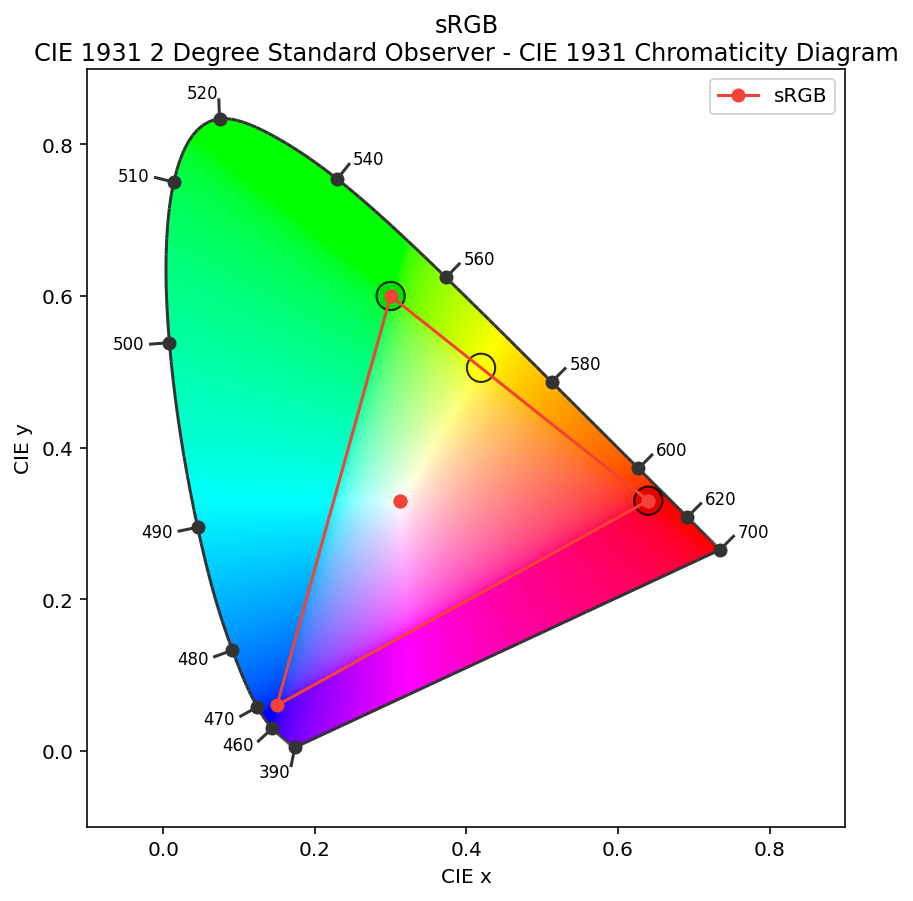

In [11]:
# Define main widgets
gsc_heatmap   = GameStatComparisionHeatmap()
kc_visualizer = KartComboVisualizer(all_combos_df)
cd_debugger   = ChromaticityDiagramDebugger()

ALL_WIDGETS = [
    DataWidget(name='Game Stat Comparision Heatmap', widget=gsc_heatmap  , debug=False),
    DataWidget(name='Kart Combo Visualizer'        , widget=kc_visualizer, debug=False),
    DataWidget(name='Chromaticity Diagram Debugger', widget=cd_debugger  , debug=True ),
]

if IS_RUNNING_BOKEH:
    # NOTE: The semicolon is needed to prevent Jupyter from rendering the template
    app = StandaloneApp(ALL_WIDGETS)
    app.serve();
else:
    MAIN_PANEL = pn.Tabs(*[
        (data_widget.name, data_widget.widget.render()) for data_widget in ALL_WIDGETS
    ])
    
    display(MAIN_PANEL)